In [1]:
!cp /content/drive/MyDrive/nlp-getting-started.zip /content/

In [2]:
import zipfile

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/word2vec-nlp-tutorial.zip','r') as zip_ref:
    zip_ref.extractall('/content/')

In [4]:
with zipfile.ZipFile('/content/labeledTrainData.tsv.zip','r') as zip_ref:
    zip_ref.extractall('/content/')

#### Library Imports

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
import string
from textblob import Word
from keras.models import Sequential
from keras.layers import Dense,LSTM,Input,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam,RMSprop

In [6]:
from tensorflow.keras.optimizers import Adam,RMSprop

In [7]:
from sklearn.model_selection import RandomizedSearchCV

In [8]:
from scikeras.wrappers import KerasClassifier

In [9]:
from gensim.models import Word2Vec

#### Download corpuses needed for data cleaning

In [10]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#### Data Cleaning

In [12]:
Swords = set(stopwords.words('english'))

In [13]:
m = 0

In [14]:
def clean_text(text):
    global m

    #Tokenize the text
    tokstr = nltk.word_tokenize(text)

    '''
    Remove pronouns,verbs and others
    pTagged = pos_tag(tokstr)

    for token, tag in pTagged:
        if tag in ['PRP', 'PRP$', 'WP', 'WP$','DT','VBZ','VBG']:
            continue
        res.append(token)'''
    #Remove punctuations
    puncRstr = [word for word in tokstr if word not in string.punctuation]

    #Remove stopwords
    stopRstr = [word for word in puncRstr if word not in Swords]

    #stemmed_token = [pStemmer.stem(word) for word in stopRstr]

    #Lemmatization
    lem_token = [Word(word).lemmatize() for word in stopRstr]

    cleaned_text = ' '.join(lem_token)

    n = len(lem_token)

    if(m < len(lem_token)):
        m = len(lem_token)

    return cleaned_text

In [15]:
Df = pd.read_csv("/content/labeledTrainData.tsv",sep="\t")

In [16]:
Df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [17]:
Df.shape

(25000, 3)

In [18]:
x = Df['review']
y = Df['sentiment']

In [19]:
x = x.apply(clean_text)

In [20]:
#Remove anything that is not alphabet or number
x = x.str.replace(r'[^A-Za-z0-9\s]+', '', regex=True)

In [21]:
x_tok = x.apply(lambda y: y.lower().split())

In [22]:
x_tok.head()

0    [with, stuff, going, moment, mj, ve, started, ...
1    [the, classic, war, worlds, timothy, hines, en...
2    [the, film, start, manager, nicholas, bell, gi...
3    [it, must, assumed, praised, film, the, greate...
4    [superbly, trashy, wondrously, unpretentious, ...
Name: review, dtype: object

In [23]:
xl = x_tok.to_list()

#### Fit the Word2Vec model on our data

In [28]:
word2vec_model = Word2Vec(sentences=xl, vector_size=75, window=5, min_count=5, workers=4, sg=1)

In [30]:
word2vec_model.save("word2vec.model")

In [31]:
def encode_text(text):
  return [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]


#### Convert our data into vectors

In [32]:
x_enc = x_tok.apply(encode_text)

In [39]:
l = x_enc.apply(len)

#### Plotting graph to find the optimum Padding length

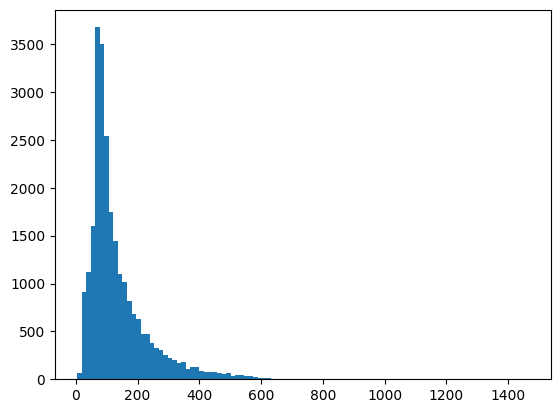

In [40]:
import matplotlib.pyplot as plt
plt.hist(l,bins=100)
plt.show()

In [41]:
max(x_enc.apply(len))

1465

###### Padding the data

In [42]:
x_pad = pad_sequences(x_enc, maxlen=175,dtype='float32', padding='post', truncating='post')

In [43]:
len(x_pad[0])

175

#### Define the model

In [47]:
model = Sequential()
model.add(Input(shape=(175, 75)))  # 100 is the dimension of word2vec embeddings
model.add(LSTM(units=75, dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
  #return model

In [45]:
x_train,x_test,y_train,y_test = train_test_split(x_pad,y,test_size=0.1,random_state=42,stratify=y)

#### Train the model

In [48]:
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5207 - loss: 0.6905 - val_accuracy: 0.5128 - val_loss: 0.6913
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5347 - loss: 0.6850 - val_accuracy: 0.7560 - val_loss: 0.5062
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8024 - loss: 0.4379 - val_accuracy: 0.8420 - val_loss: 0.3750
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8364 - loss: 0.3740 - val_accuracy: 0.8344 - val_loss: 0.3713
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8390 - loss: 0.3644 - val_accuracy: 0.8440 - val_loss: 0.3545
